# CorrSeg

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

# sklearn
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

### Loading data

                  0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_10_patch_0   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_1   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_10  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_11  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_12  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...              .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_15_patch_95  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_96  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_97  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_98  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_99  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                  1290  1291  1292  1293  1294  129

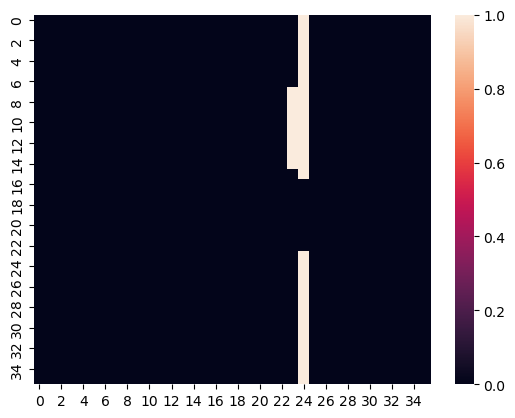

In [ ]:
# Read file
y_train = pd.read_csv('../y_train_PlZf4rH.csv', index_col=0) #Table with index being the name of the patch
print(y_train)
y_1_130 = np.array(y_train.loc['well_1_patch_130'])

# Access to one patch label
sns.heatmap(np.array(y_train.loc['well_1_patch_40']).reshape(36, 36))
print(np.array(y_train.loc['well_1_patch_126']).reshape(36, 36))

# Get all labels at once
# y_train.values.reshape((-1,36,36))

In [ ]:
x = np.load('../images/well_1_patch_40.npy')
x.shape

(36, 36)

In [ ]:
path = Path('../images')
image_paths = np.array([x for x in path.iterdir()])
print(image_paths)
image_names = np.array([str(x).split('/')[2].split('.')[0] for x in image_paths]) # extracting image path names into a list in order to reindex labels
n = len(image_paths)
images_array = np.empty((n, 36, 36), dtype=np.float32)

for i, path in enumerate(image_paths):
    if path != image_paths[i]: 
        print('chaos')
    # print("at ", i, "of", n)
    images_array[i] = np.load(path)


[PosixPath('../images/well_11_patch_983.npy')
 PosixPath('../images/well_7_patch_88.npy')
 PosixPath('../images/well_11_patch_1434.npy') ...
 PosixPath('../images/well_7_patch_91.npy')
 PosixPath('../images/well_11_patch_742.npy')
 PosixPath('../images/well_3_patch_366.npy')]


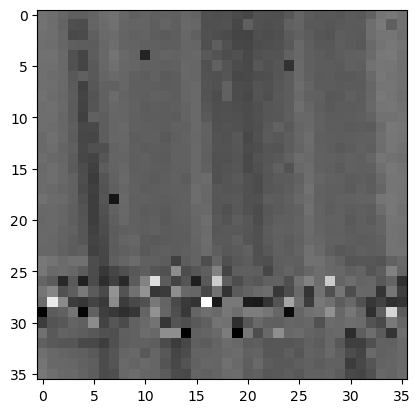

In [ ]:
plt.imshow(images_array[9] * 255, cmap='gray')

## EDA

-0.006815046


/Users/Andrej/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


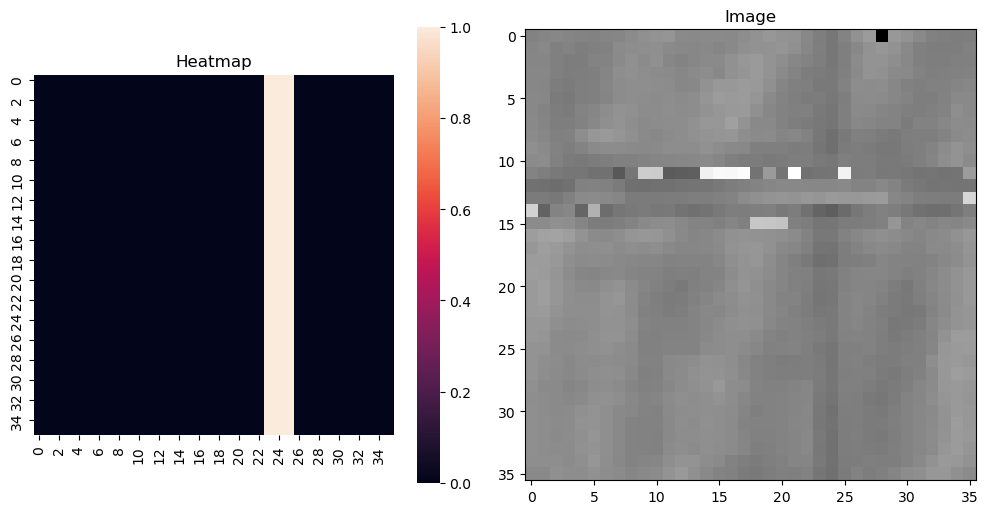

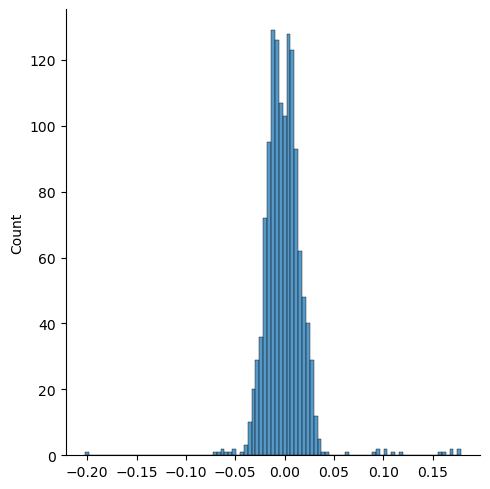

In [ ]:
well_patch = 'well_1_patch_135'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(np.array(y_train.loc[well_patch]).reshape(36, 36), ax=axes[0])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

x = np.load(f'../images/{well_patch}.npy')
axes[1].imshow(x * 255, cmap='gray')
axes[1].set_title('Image')

plt.tight_layout()

sns.displot(x.reshape(-1))
print(x[32, 30])

In [ ]:
print(np.unique(images_array))
# np.equal(images, nan)
np.argwhere(images_array == np.nan)

[-9.9925000e+02 -9.9900000e+02 -9.3992406e-01 ...  4.2167890e-01
  4.7034341e-01            nan]


array([], shape=(0, 3), dtype=int64)

In [ ]:
np.min(images_array)

nan

In [ ]:
# sns.histplot(images.reshape(n * 36 * 36))

## Preprocessing

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
images_array_imp = imputer.fit_transform(images_array.reshape(n, 36*36)).reshape(n, 36, 36)

In [ ]:
# leaving outliers for now, using robust scaler
scaler = RobustScaler()
for i, image in enumerate(images_array_imp):
    scaler.fit_transform(image)

## Pipeline

In [ ]:
steps = [('imputer', SimpleImputer())]

## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

In [ ]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Encoder (downsampling pathway)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Decoder (upsampling pathway)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1) # 64 in_ch cause concatination
        
        # Output layer
        self.conv4 = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        print(x.shape)
        # Encoder
        x1 = F.relu(self.conv1(x))
        print("x1", x1.shape)
        print("x1 post", F.max_pool2d(x1, 2).shape)
        x2 = F.relu(self.conv2(F.max_pool2d(x1, 2)))
        
        # Decoder
        print("x2", x2.shape)
        x = F.relu(self.deconv1(x2))
        print("x2 post", torch.cat([x1, x], 1).shape)
        x = F.relu(self.conv3(torch.cat([x1, x], 1)))
        print("x3", x.shape)
        
        # Output layer
        x = torch.sigmoid(self.conv4(x))  # Sigmoid activation for binary classification
        print("final", x.shape)
        # print(torch.softmax(self.conv4(x)))
        
        return x


In [78]:
model = CNN()

In [79]:
from torchsummary import summary

summary(model, input_size=(1, 36, 36))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─ConvTranspose2d: 1-3                   8,224
├─Conv2d: 1-4                            9,232
├─Conv2d: 1-5                            17
Total params: 36,289
Trainable params: 36,289
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─ConvTranspose2d: 1-3                   8,224
├─Conv2d: 1-4                            9,232
├─Conv2d: 1-5                            17
Total params: 36,289
Trainable params: 36,289
Non-trainable params: 0

In [80]:
labels = y_train.reindex(image_names)
print(image_names)
id = 89
# plt.imshow(images[id] * 255)

cutoff = 7700
print("images: ", images_array_imp.shape)
X_train = torch.tensor(images_array_imp[:cutoff], dtype=torch.float32, device=mps_device)
X_val = torch.tensor(images_array_imp[cutoff:], dtype=torch.float32, device=mps_device)
print("x shape", X_train.shape)

y_training = torch.tensor(labels.values[:cutoff].reshape(-1, 36, 36), dtype=torch.float32, device=mps_device)
print(y_training.shape)
y_val = torch.tensor(labels.values[cutoff:].reshape(-1, 36, 36), dtype=torch.float32, device=mps_device)

train_set = torch.utils.data.TensorDataset(
    X_train, 
    y_training)
val_set = torch.utils.data.TensorDataset(
    X_val, 
    y_val)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

['well_11_patch_983' 'well_7_patch_88' 'well_11_patch_1434' ...
 'well_7_patch_91' 'well_11_patch_742' 'well_3_patch_366']
images:  (9674, 36, 36)
x shape torch.Size([7700, 36, 36])
torch.Size([7700, 36, 36])


In [81]:
from torchmetrics import JaccardIndex

def jaccard_loss(y_true, y_pred, smooth=100.0):
    intersection = torch.sum( y_true * y_pred, axis=-1)
    union = torch.sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return (1 - jac) * smooth


torch.Size([128, 1, 36, 36])
x1 torch.Size([128, 32, 36, 36])
x1 post torch.Size([128, 32, 18, 18])
x2 torch.Size([128, 64, 18, 18])
x2 post torch.Size([128, 64, 36, 36])
final torch.Size([128, 1, 36, 36])
torch.Size([128, 1, 36, 36])
x1 torch.Size([128, 32, 36, 36])
x1 post torch.Size([128, 32, 18, 18])
x2 torch.Size([128, 64, 18, 18])
x2 post torch.Size([128, 64, 36, 36])
final torch.Size([128, 1, 36, 36])
torch.Size([128, 1, 36, 36])
x1 torch.Size([128, 32, 36, 36])
x1 post torch.Size([128, 32, 18, 18])
x2 torch.Size([128, 64, 18, 18])
x2 post torch.Size([128, 64, 36, 36])
final torch.Size([128, 1, 36, 36])
torch.Size([128, 1, 36, 36])
x1 torch.Size([128, 32, 36, 36])
x1 post torch.Size([128, 32, 18, 18])
x2 torch.Size([128, 64, 18, 18])
x2 post torch.Size([128, 64, 36, 36])
final torch.Size([128, 1, 36, 36])
torch.Size([128, 1, 36, 36])
x1 torch.Size([128, 32, 36, 36])
x1 post torch.Size([128, 32, 18, 18])
x2 torch.Size([128, 64, 18, 18])
x2 post torch.Size([128, 64, 36, 36])
final

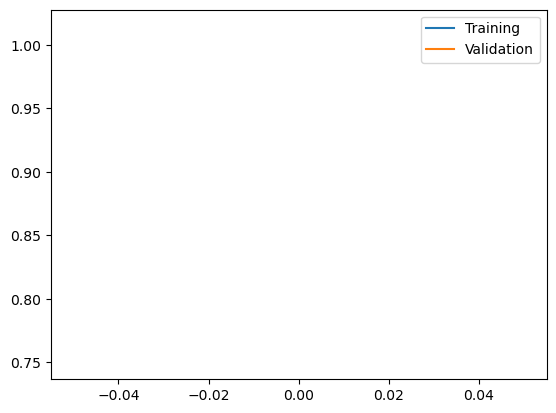

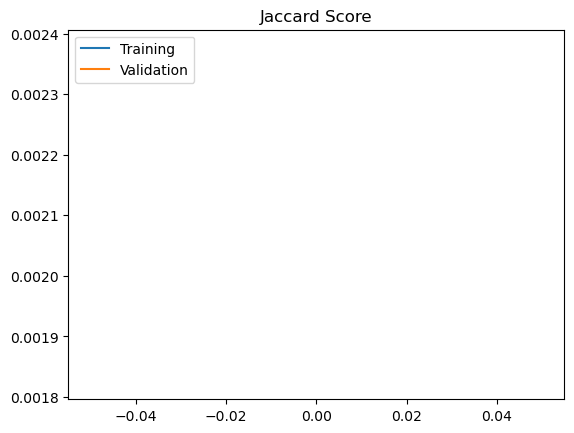

: 

In [86]:
# Instantiate the model
model = CNN()
model.to(mps_device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 1
loss_scores = []
val_loss_scores = []
jacc_scores = []
val_jacc_scores = []
jaccard = JaccardIndex(task='binary').to(mps_device)
for epoch in range(num_epochs):
    model.train()
    jacc_score = 0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(labels)
        jacc_score += jaccard(outputs, labels.unsqueeze(1))
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_jacc_score = 0
        for images, labels in val_loader:
            images = images.unsqueeze(1) # adding a dimention for the channel
            labels = labels.unsqueeze(1) # adding a dimention for the channel
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Jaccard
            val_jacc_score += jaccard(outputs, labels).cpu()
    
    # jacc_scores.append(jacc_score)
    loss_scores.append(loss.item())
    jacc_scores.append(jacc_score.cpu()/len(train_loader))
    val_loss_scores.append(val_loss/len(val_loader))
    val_jacc_scores.append(val_jacc_score.cpu()/len(val_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

torch.save(model.state_dict(), f'trained_model_e:{epoch}_{time.localtime()}.pth')


plt.plot(loss_scores)
plt.plot(val_loss_scores)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(jacc_scores)
plt.plot(val_jacc_scores)
plt.title('Jaccard Score')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


In [ ]:
jacc_scores = np.array([score.cpu() for score in jacc_scores])
val_jacc_scores = [score.cpu() for score in val_jacc_scores]

plt.plot(jacc_scores)
plt.plot(val_jacc_score)
plt.title('Jaccard Score')
plt.show()

NameError: name 'np' is not defined

In [ ]:
np.save(f"loss_scores_{time.localtime()}.npy", arr=loss_scores)
np.save(f"val_loss_scores_{time.localtime()}.npy", arr=val_loss_scores)

/Users/Andrej/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


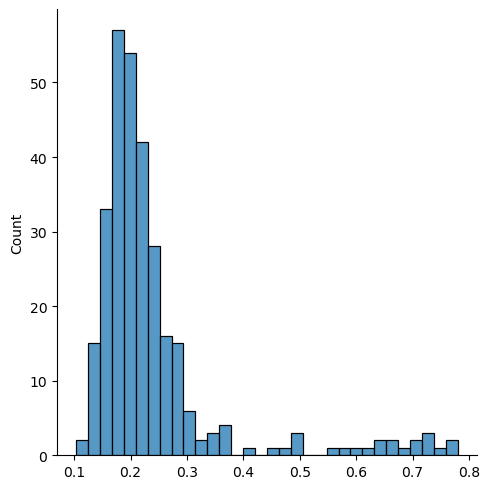

In [ ]:
sns.displot(loss_scores)

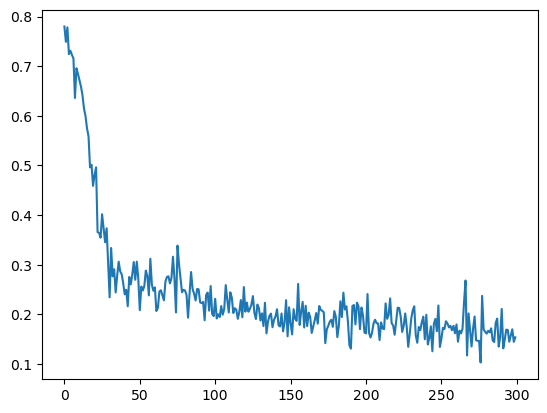

In [ ]:
plt.plot(range(len(val_loss_scores)), loss_scores)

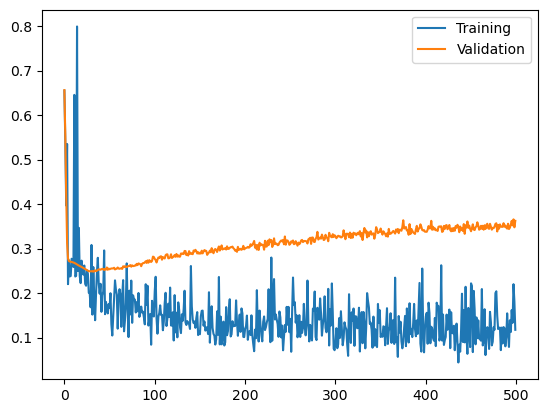

In [ ]:
l = np.load('loss_scores_time.struct_time(tm_year=2024, tm_mon=5, tm_mday=2, tm_hour=18, tm_min=17, tm_sec=51, tm_wday=3, tm_yday=123, tm_isdst=1).npy')
v = np.load('val_loss_scores_time.struct_time(tm_year=2024, tm_mon=5, tm_mday=2, tm_hour=18, tm_min=17, tm_sec=51, tm_wday=3, tm_yday=123, tm_isdst=1).npy')
plt.plot(l)
plt.plot(v)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
predictions = pd.DataFrame(columns=[str(i) for i in range(1296)])

test_path = Path('./images_test')

with torch.no_grad():
    for path in test_path.iterdir():
        # print(str(path).split('/')[1])
        img = torch.from_numpy(np.load(path)).unsqueeze(0).to(mps_device)
        name = str(path).split('/')[1].split('.')[0]
        pred = model(img.unsqueeze(0))
        pred = np.where(pred.cpu() >= 0.5, 1, 0).reshape(-1)
        predictions.loc[name] = pd.Series(pred, index=[str(i) for i in range(1296)])

print(predictions)
predictions.to_csv('predictions.csv')


                   0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_5_patch_1485  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_567   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_201   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     1   
well_3_patch_57    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_419   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...               .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_3_patch_372   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_414   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_400   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_218   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_366   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                   1290  1291  1292  12